In [103]:
%matplotlib ipympl

from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import scatter
from scipy.constants import Avogadro
import pandas as pd
from ipywidgets import interact

### HW 2 Scattering & Diffraction Basics

**Q1:** Crystallographers frequently use the two units, $Å$ and $keV$, to describe the X-rays they use in an experiment. Being able to convert between the two is often helpful in discussing experimental design. Use the two widgets in the next cell to get a feel for these units. 
 - A lot of crystallography happens at or around 1 $Å$, what is this in eV?
 - Most home sources for macromolecular crystallography have a Copper anode with a wavelength of 1.5406 $Å$. what is this in eV?
 - 

In [132]:
from reciprocalspaceship.utils import ev2angstroms, angstroms2ev

print("Wavelength to Energy converter:")

@interact(wavelength=str(1.))
def f(wavelength):
    try:
        return angstroms2ev(float(wavelength))
    except ValueError:
        return None


print("\nEnergy to wavelength converter:")
@interact(eV=str(angstroms2ev(1.)))

def f(eV):
    try:
        return f"{ev2angstroms(float(eV)):0.2f} Å"
    except ValueError:
        return None



Wavelength to Energy converter:


interactive(children=(Text(value='1.0', description='wavelength'), Output()), _dom_classes=('widget-interact',…


Energy to wavelength converter:


interactive(children=(Text(value='12398.419843320027', description='eV'), Output()), _dom_classes=('widget-int…

In [117]:
"124.1".isalnum()

False

/tmp/ipykernel_140799/1922586181.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax = plt.pcolor(Xi[:,0].reshape((n,n)), Xi[:,1].reshape((n,n)), Zi, norm=norm)


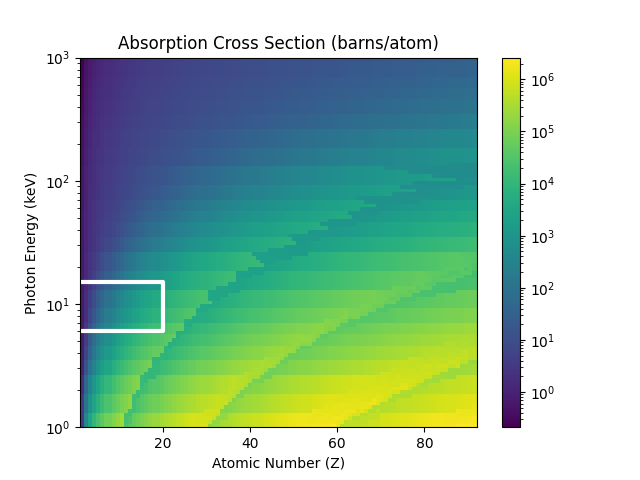

In [14]:
df = pd.read_csv('mass_coefficients.csv', names = ['', 'Energy', 'mu/rho', 'mu_en/rho', 'Z'], header=1)
df['Energy'] = df['Energy']*1000.

mass = pd.read_csv("atomic_mass.csv", delim_whitespace=True)
mass

df = df.join(mass.set_index('Z'), on='Z')

df['SIGMA'] = df['mu/rho']*df['Mass']/Avogadro

#This is nearest neighbor interpolation
ykey = 'Energy'
xkey = 'Z'
zkey = 'SIGMA'


X = df[xkey].values
Y = df[ykey].values
Z = df[zkey].values


n = 100
Zi = np.zeros((n, n))

Xi = np.dstack(np.meshgrid(
    np.linspace(X.min(), X.max(), n),
    np.logspace(0, 3, n)
))
Xi = Xi.reshape((n**2, 2))
Xo = np.vstack((X, Y)).T

idx = np.argmin(np.linalg.norm(Xi[:,None] - Xo, 2, 2), 1)
Zi  = Z[idx].reshape((n,n)) * 1e24

norm = mpl.colors.LogNorm(Zi.min(), Zi.max())

plt.figure()
ax = plt.pcolor(Xi[:,0].reshape((n,n)), Xi[:,1].reshape((n,n)), Zi, norm=norm)
plt.colorbar()
plt.title("Absorption Cross Section (barns/atom)")
plt.xlabel("Atomic Number (Z)")
plt.ylabel("Photon Energy (keV)")
plt.yticks(range(0, 100, 10))
xlim = plt.xlim()
plt.plot([0, 20, 20, 0], [6, 6, 15, 15], 'w', linewidth=3)
plt.xlim(xlim)
plt.yscale('log')


In [98]:
def scattering_cross_section(Z=None):
    num_points = 500
    theta = np.deg2rad(np.linspace(0, 180, num_points))
    ko = 1
    phi = 0.25*np.pi #This represents total scattering
    dI_thomson = scatter.thomson(theta, phi, ko, Z) 
    dI_compton = scatter.compton(theta, phi, ko, Z)
    f = plt.figure(figsize=(8,8))
    x = np.pi - theta
    ax1, ax2, ax3 = plt.polar(
        np.column_stack((x, x, x)),
        np.column_stack((dI_thomson + dI_compton, dI_thomson, dI_compton)),
        label=("Total", "Elastic (Thomson)", "Inelastic (Compton)")
    )

    plt.xlabel(r"$Differential\ Scattering\ Cross\ Section\ (barns\cdot sr^{-1})$")
    f.canvas.draw()
    ax = plt.gca()
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    plt.legend()
    plt.title("Differential Scattering\n{:1.2e} eV".format(ko))
    plt.tight_layout()


    @interact(logeV = (0., 6, 0.1))
    def update(logeV=0.):
        ko = 10.**logeV
        print(ko)
        plt.title("Differential Scattering\n{:1.2e} eV".format(ko))
        dI_thomson = scatter.thomson(theta, phi, ko, Z) 
        dI_compton = scatter.compton(theta, phi, ko, Z)
        
        ax1.set_data(np.pi - theta, dI_thomson + dI_thomson)
        ax2.set_data(np.pi - theta, dI_thomson)
        ax3.set_data(np.pi - theta, dI_compton)
        plt.xlabel(r"$Differential\ Scattering\ Cross\ Section\ (barns\cdot sr^{-1})$")
        f.canvas.draw_idle()


interactive(children=(FloatSlider(value=0.0, description='logeV', max=6.0), Output()), _dom_classes=('widget-i…

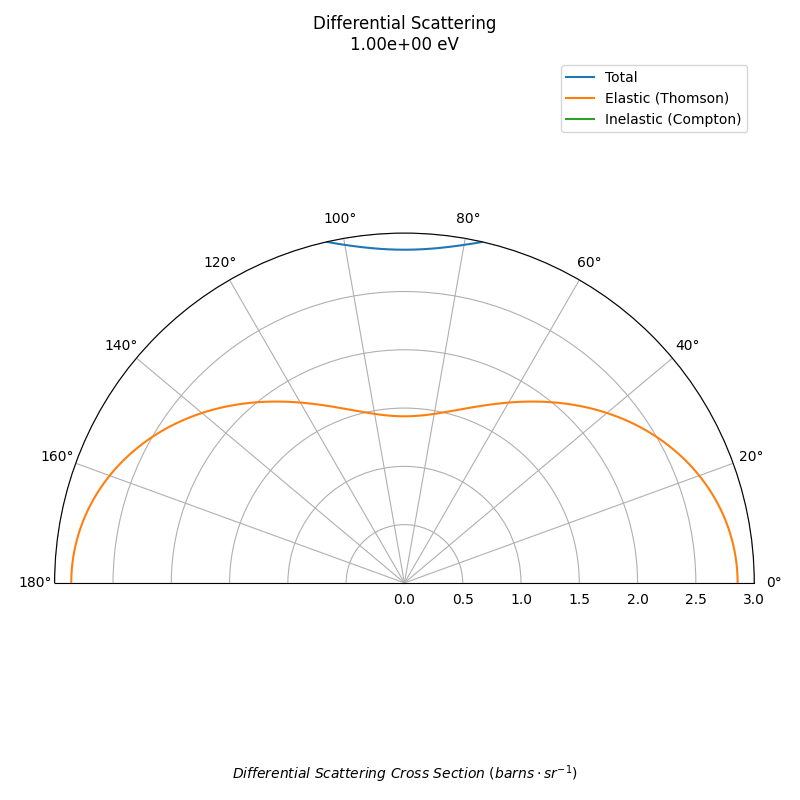

In [100]:
# This is the differential scattering for Carbon. 
# What do you notice about the directionality of scattering by carbon atoms in the X-ray regime (~10 keV)?
# How does this compare to the free electron?
scattering_cross_section(6)

In [76]:
def scattering_cross_section(Z=None):
    from ipywidgets import interact
    num_points = 500
    theta = np.deg2rad(np.linspace(0, 180, num_points))
    ko = 1

    dI_para = scatter.differential_intensity(theta, np.zeros(num_points), ko, Z) 
    dI_perp = scatter.differential_intensity(theta, 0.5*np.pi*np.ones(num_points), ko, Z)
    f = plt.figure(figsize=(8,8))
    x = np.pi - theta
    ax1, ax2, ax3 = plt.polar(
        np.column_stack((x, x, x)),
        np.column_stack((dI_para, dI_perp, dI_para + dI_perp)),
        label=(r"$\parallel$", r"$\bot$", r"$\parallel + \bot$")
    )

    plt.xlabel(r"$Differential\ Scattering\ Cross\ Section\ (barns\cdot sr^{-1})$")
    f.canvas.draw()
    ax = plt.gca()
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    plt.legend()
    plt.title("Differential Scattering\n{:1.2e} eV".format(ko))
    plt.tight_layout()


    @interact(logeV = (0., 6, 0.1))
    def update(logeV=0.):
        ko = 10.**logeV
        print(ko)
        plt.title("Differential Scattering\n{:1.2e} eV".format(ko))
        dI_para = scatter.differential_intensity(theta, np.zeros(num_points), ko, Z) 
        dI_perp = scatter.differential_intensity(theta, 90.*np.ones(num_points), ko, Z)

        ax1.set_data(np.pi - theta, dI_para)
        ax2.set_data(np.pi - theta, dI_perp)
        ax3.set_data(np.pi - theta, dI_perp + dI_para)
        plt.xlabel(r"$Differential\ Scattering\ Cross\ Section\ (barns\cdot sr^{-1})$")
        f.canvas.draw_idle()


interactive(children=(FloatSlider(value=0.0, description='logeV', max=6.0), Output()), _dom_classes=('widget-i…

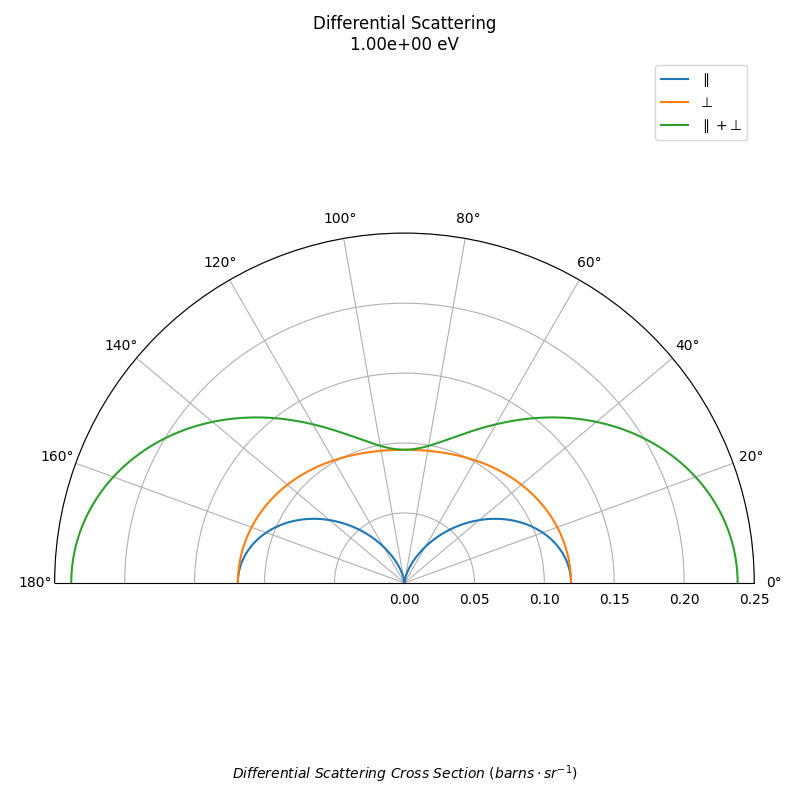

In [78]:
# This is the differential scattering for Carbon. 
# What do you notice about the directionality of scattering by carbon atoms in the X-ray regime (~10 keV)?
# How does this compare to the free electron?
scattering_cross_section(None)